<a href="https://colab.research.google.com/github/Kirill-Shokhin/Coursera-ML-/blob/main/%D0%9F%D0%BE%D0%B8%D1%81%D0%BA%20%D1%81%D1%82%D1%80%D1%83%D0%BA%D1%82%D1%83%D1%80%D1%8B%20%D0%B2%20%D0%B4%D0%B0%D0%BD%D0%BD%D1%8B%D1%85/Banner_placement.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Banner placement
Представим, что международное круизное агентство Carnival Cruise Line решило себя разрекламировать с помощью баннеров и обратилось для этого к вам. Чтобы протестировать, велика ли от таких баннеров польза, их будет размещено всего 20 штук по всему миру. Вам надо выбрать 20 таких локаций для размещения, чтобы польза была большой и агентство продолжило с вами сотрудничать.

Агентство крупное, и у него есть несколько офисов по всему миру. Вблизи этих офисов оно и хочет разместить баннеры — легче договариваться и проверять результат. Также эти места должны быть популярны среди туристов.

Для поиска оптимальных мест воспользуемся базой данных крупнейшей социальной сети, основанной на локациях — Foursquare.

Часть открытых данных есть, например, на сайте archive.org:

https://archive.org/details/201309_foursquare_dataset_umn

Скачаем любым удобным образом архив fsq.zip с этой страницы.

Нас будет интересовать файл checkins.dat.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!ls '/content/drive/MyDrive/Colab Notebooks'

'Banner placement.ipynb'   checkins.dat


Для удобной работы с этим документом преобразуем его к формату csv, удалив строки, не содержащие координат — они неинформативны для нас:

In [ ]:
import pandas as pd
import numpy as np
data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/checkins.dat", sep='|', header=None, skiprows=2,
                   low_memory = False, skipinitialspace=True,
                   names=['id','user_id','venue_id','latitude','longitude','created_at'])
data.dropna(subset=['latitude', 'longitude'], inplace = True)
data.reset_index(inplace=True, drop=True)
data.shape

(396634, 6)

In [ ]:
data.head()

,id,user_id,venue_id,latitude,longitude,created_at
0,984222,15824.0,5222.0,38.895112,-77.036366,2012-04-21 17:43:47
1,984234,44652.0,5222.0,33.800745,-84.410520,2012-04-21 17:43:43
2,984291,105054.0,5222.0,45.523452,-122.676207,2012-04-21 17:39:22
3,984318,2146539.0,5222.0,40.764462,-111.904565,2012-04-21 17:35:46
4,984232,93870.0,380645.0,33.448377,-112.074037,2012-04-21 17:38:18


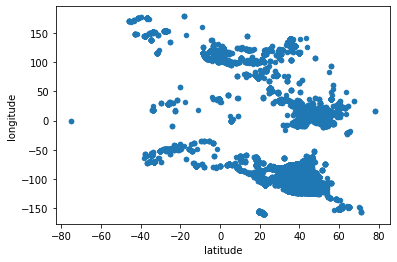

In [ ]:
X = data[['latitude', 'longitude']]
X.plot(x='latitude', y='longitude', kind='scatter')

Теперь необходимо кластеризовать данные координаты, чтобы выявить центры скоплений туристов. Поскольку баннеры имеют сравнительно небольшую площадь действия, нам нужен алгоритм, позволяющий ограничить размер кластера и не зависящий от количества кластеров.

Эта задача — хороший повод познакомиться с алгоритмом MeanShift, который мы обошли стороной в основной части лекций. Используйте MeanShift, указав bandwidth=0.1, что в переводе из градусов в метры колеблется примерно от 5 до 10 км в средних широтах.

In [ ]:
from sklearn.cluster import MeanShift
clustering = MeanShift(bandwidth=0.1).fit(X)

In [ ]:
labels = clustering.labels_
cluster_centers = clustering.cluster_centers_

n_clusters_ = len(cluster_centers)
n_clusters_

5536

Некоторые из получившихся кластеров содержат слишком мало точек — такие кластеры не интересны рекламодателям. Поэтому надо определить, какие из кластеров содержат, скажем, больше 15 элементов. Центры этих кластеров и являются оптимальными для размещения.

При желании увидеть получившиеся результаты на карте можно передать центры получившихся кластеров в один из инструментов визуализации. Например, сайт mapcustomizer.com имеет функцию Bulk Entry, куда можно вставить центры полученных кластеров в формате:

In [ ]:
a = pd.Series(labels).value_counts() 
big_clusters = a[a > 15]
centers = cluster_centers[big_clusters.index]

ак мы помним, 20 баннеров надо разместить близ офисов компании. Найдем на Google Maps по запросу Carnival Cruise Line адреса всех офисов:

In [ ]:
offices = np.array([[33.751277, -118.188740],  #Los Angeles
                    [25.867736, -80.324116],   #Miami
                    [51.503016, -0.075479],    #London
                    [52.378894, 4.885084],     #Amsterdam
                    [39.366487, 117.036146],   #Beijing
                    [-33.868457, 151.205134]]) #Sydney


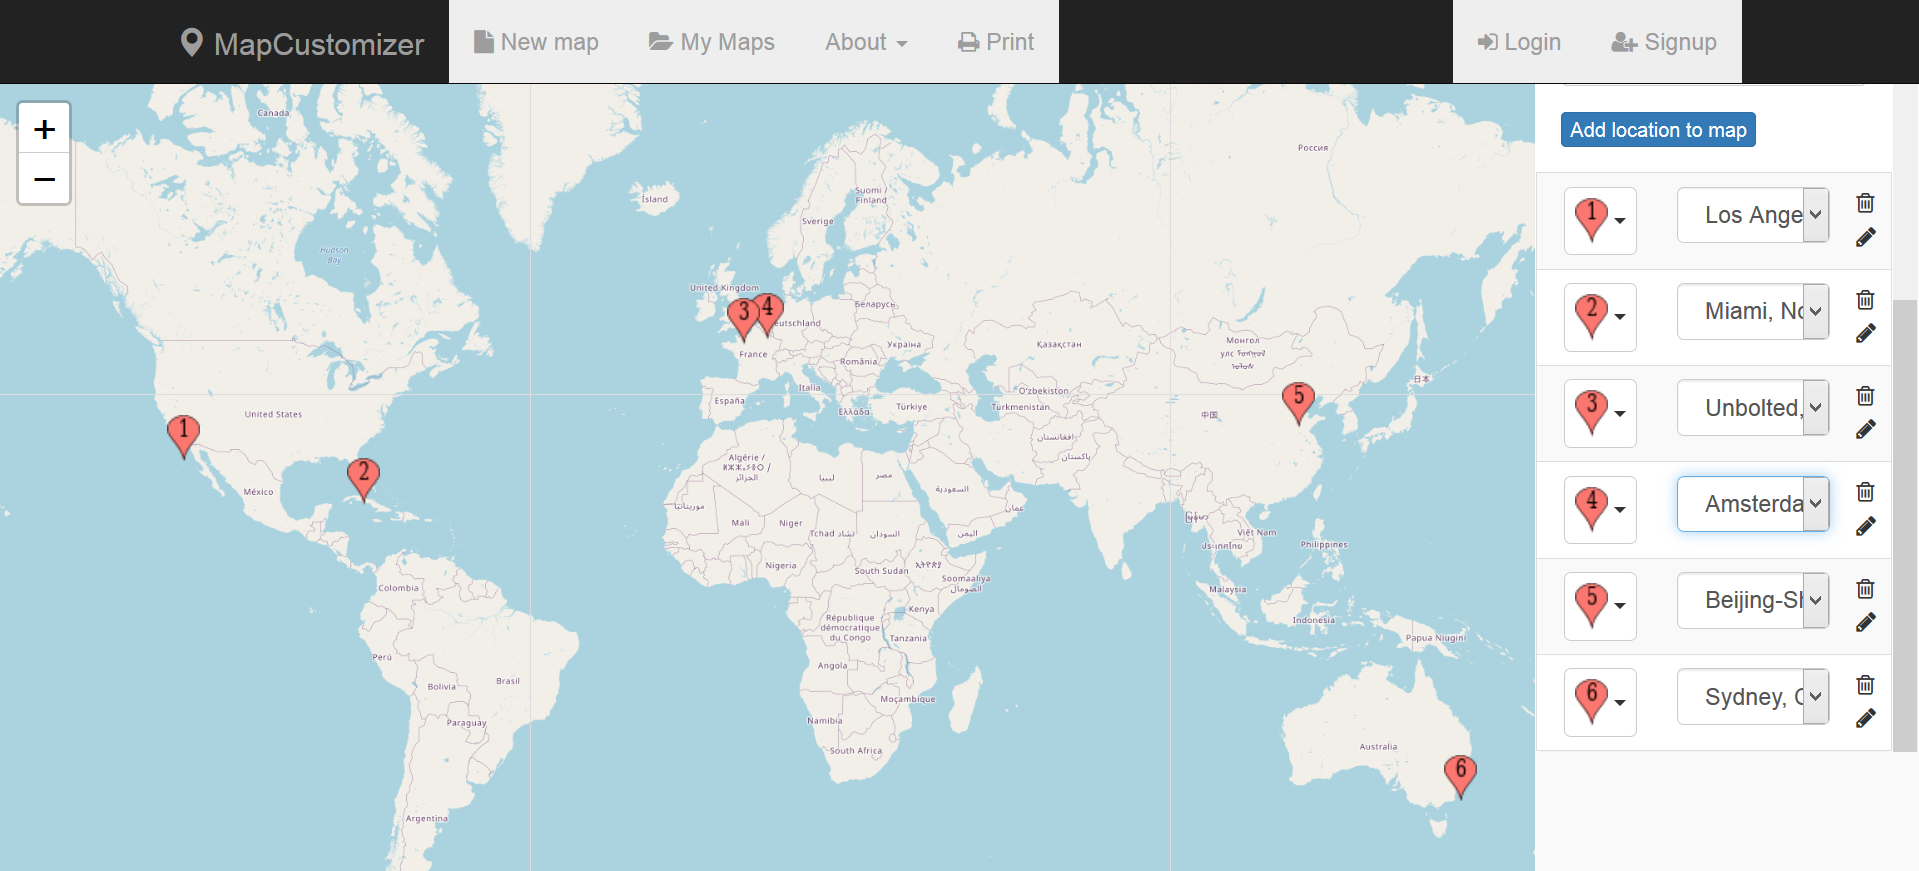

Осталось определить 20 ближайших к ним центров кластеров. Т.е. посчитать дистанцию до ближайшего офиса для каждой точки и выбрать 20 с наименьшим значением.

In [ ]:
from geopy.distance import geodesic
distances=[]
for i, center in enumerate(centers):
  distance_to_office = np.zeros(len(offices))
  for j, office in enumerate(offices):
    distance_to_office[j] = geodesic(office, center).km
  k = np.argmin(distance_to_office)
  distances.append([distance_to_office[k], i])
distances.sort()

In [ ]:
array = np.array(distances, dtype=float)
dist = np.around(array[:, 0], 3)
idx = array[:,1].astype(int)
centers[idx].shape

(1304, 2)

####Координаты размещения баннеров

In [ ]:
pd.DataFrame({'Latitude' : centers[idx, 0],
              'Longitude' : centers[idx, 1],
              'Distance to the nearest office, km' : dist})[:20]

,Latitude,Longitude,"Distance to the nearest office, km"
0,-33.866146,151.207082,0.313
1,52.372489,4.892268,0.864
2,25.846206,-80.311245,2.712
3,51.503055,-0.127113,3.585
4,33.811275,-118.144334,7.823
5,25.787086,-80.215128,14.115
6,51.480366,-0.308323,16.367
7,26.005052,-80.205598,19.297
8,33.898488,-118.062259,20.093
9,51.598314,-0.321786,20.107
